### Python libraries 
Please activate the Conda environment you created in the terminal command line, and then execute the following commands **line by line** (the first command changes the default pip source to the Tsinghua mirror, which is recommended):
```
conda create -n class2_env python=3.8
conda activate class2_env
pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
pip install numpy
pip install rdkit
pip install ipykernel
pip install fair-esm
pip install matplotlib
pip install transformers
pip install scikit-learn
pip install pandas
pip install tqdm
pip install biopython
pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 -f https://mirrors.aliyun.com/pytorch-wheels/cu118
pip install xgboost
pip install hyperopt
```

## Small Molecule Substrates of Enzymes
### Prediction of enzyme-substrate pairs (ESP)

## The exercise today is mainly about how to train an enzyme-substrate pair prediction model and analysis, which includes:

1. Data preprocessing including knowledge review of substrate and protein/enzyme embedding generation
2. Load and clean the data of enzyme-substrate pair
3. Train a machine learning model for enzyme-substrate pair prediction model
4. Predict the substrate for given sequences



## 1. Data Preprocessing and Cleaning

### 1.1 Substrate Feature Extraction (Knowledge review)<a id="compound-feature-extraction-methods"></a>

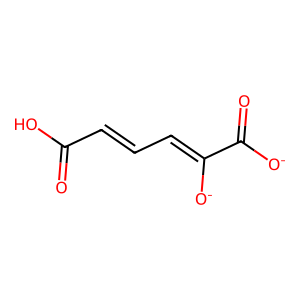

In [1]:
# Import necessary libraries from RDKit
from rdkit import Chem
from rdkit.Chem import Draw
# smiles of a molecule

smiles = 'C(=CC(=O)O)C=C(C(=O)[O-])[O-]'  # SMILES for 2-Hydroxymuconate

# smiles to molecule
mol = Chem.MolFromSmiles(smiles)

# visualize molecule
Draw.MolToImage(mol)

### 1.1.1 Molecular Fingerprints (Knowledge review)
- **Definition**: A molecular fingerprint is a method of converting the structure of a molecule into a fixed-length binary vector. This vector represents the presence or absence of specific substructures or features within the molecule.
- **Example**:
  - **Morgan Fingerprint (ECFP)**: Extended-Connectivity Fingerprints are a type of circular fingerprint that captures the local environment of each atom in a molecule. For instance, an ECFP4 fingerprint with a radius of 2 and a bit vector length of 1024 bits can be generated using RDKit.
  - **MACCS Keys**: MACCS (Molecular ACCess System) keys are another type of molecular fingerprint that uses a predefined set of 166 structural keys.
  - **RDKit Example Code**:

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Load a molecule from a SMILES string
mol = Chem.MolFromSmiles('CCO') # SMILES 'CCO' corresponds to the molecule ethanol (C2H5OH)

# Generate the Morgan fingerprint
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)# 2 is the radius of the fingerprint and 1024 is the length of the fingerprint

# Convert to a numpy array for further processing
fingerprint_array1 = np.array(fp1)
print('Fingerprint for CCO:', fingerprint_array1)
print('Shape of fingerprint for CCO:', fingerprint_array1.shape)

Fingerprint for CCO: [0 0 0 ... 0 0 0]
Shape of fingerprint for CCO: (1024,)


[06:51:51] DEPRECATION WARNING: please use MorganGenerator


In [3]:
# Generate the MACCS keys
fp2 = AllChem.GetMACCSKeysFingerprint(mol)
fingerprint_array2 = np.array(fp2)
print('MACCS keys fingerprint for CCO:', fingerprint_array2)
print('Shape of MACCS keys fingerprint for CCO:', fingerprint_array2.shape)

MACCS keys fingerprint for CCO: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0]
Shape of MACCS keys fingerprint for CCO: (167,)


### 1.1.2 Substrate Pretrained Models
- **Definition**: Substrate language models, such as ChemBERTa, are pre-trained deep learning models that can encode substrate sequences into numerical representations.  These models capture the contextual information and structural properties of the molecules in the substrate sequence.
There are many pretrained models for compounds, if you are interested, please check [this github repo](https://github.com/junxia97/awesome-pretrain-on-molecules) for further information. 
- **Example**:
Here we will use one of them [ChemBERTa](https://arxiv.org/abs/2010.09885) as one example:
The ChemBERTa-77M-MTR model was pretrained on a dataset containing 77M unique SMILES.
ChemBERTa-77M-MTR accepts SMILES of molecules as input and generates embedding vectors of the input SMILES, which can be used for a variety of downstream tasks including molecular property prediction, which is used for predicting a variety of physicochemical properties of a molecule, and drug-drug interactions, among others.

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import warnings

warnings.filterwarnings("ignore")

# Define the path to the pre-trained ChemBERTa model
SMILES_BERT = "/data/home/jiahao/class2/ChemBERTa-77M-MTR"

# Initialize an empty dictionary to store SMILES representations
smiles_reprs = {}

# Load the tokenizer for the pre-trained ChemBERTa model
smiles_tokenizer = AutoTokenizer.from_pretrained(SMILES_BERT)

# Load the pre-trained ChemBERTa model for masked language modeling
smiles_bert = AutoModelForMaskedLM.from_pretrained(SMILES_BERT)

In [5]:
# Input SMILES and generate embedding vectors of the input SMILES.
def get_last_layer_repr(smiles):
    """
    Function to get the last layer representation (logits) of a given SMILES string using the pre-trained ChemBERTa model.
    
    Args:
    - smiles (str): The SMILES string for which to obtain the representation.
    
    Returns:
    - last_layer_repr (torch.Tensor): The logits (last layer representation) of the SMILES string.
    """
    
    # Use the predefined tokenizer
    tokenizer = smiles_tokenizer
    
    # Use the predefined model
    model = smiles_bert
    
    # Freeze the model parameters to prevent backpropagation
    for param in model.parameters():
        param.requires_grad = False
    
    # Move the model to the CPU
    model = model.to('cpu')
    
    # Set the model to evaluation mode
    model.eval()
    
    # Define the key to extract the logits from the model output
    key = "logits"
    
    # Define the maximum length for tokenization
    max_length = 500
    
    # Tokenize the SMILES string
    tokens = tokenizer(
        smiles,
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    
    # Get the last layer representation (logits) by passing the tokenized input through the model
    last_layer_repr = model(**tokens)[key]
    
    # Return the last layer representation
    return last_layer_repr

In [6]:
# This is one example of how we can use the ChemBERTa to generate embedding represention of the molecule 2-Ethylcyclobutanone, O=C2CCC2CC is inputted using its SMILES.
last_layer_repr = get_last_layer_repr('O=C2CCC2CC')
print('Representation of O=C2CCC2CC:', last_layer_repr)

Representation of O=C2CCC2CC: tensor([[[ 0.0048,  0.0000,  0.3266,  ...,  0.3541,  0.8186,  0.3482],
         [ 1.5164,  0.0000, -0.0092,  ...,  0.1795,  0.5670,  0.2165],
         [ 1.5115,  0.0000, -0.0049,  ...,  0.1796,  0.5666,  0.2165],
         ...,
         [ 1.4013,  0.0000,  0.1335,  ...,  0.1943,  0.5182,  0.1489],
         [ 1.4157,  0.0000,  0.1311,  ...,  0.1816,  0.5249,  0.1419],
         [ 1.3734,  0.0000,  0.0209,  ...,  0.1812,  0.7134,  0.2461]]])


### Question 1 Could you generate the ChemBERTa embedding for ethanol? You need to find the SMILES of ethanol by yourself and then using code to generate embeding

In [7]:
# type your code here

## 1.2 Protein Sequence Feature Extraction (Knowledge review)
### 1.2.1 Protein Language Models
- **Definition**: Protein language models, such as ESM2 (Evolutionary Scale Modeling 2), are pre-trained deep learning models that can encode protein sequences into numerical representations. These models capture the contextual information and structural properties of amino acids in the sequence.
- There are different variants of ESM2 with parameter counts ranging from 35M to 15B. Among them, the commonly used ESM2-T33-650M_UR50D model has about 650 million parameters.
- ESM2 was pretrained on large-scale protein sequence databases, including UniRef50 (a non-redundant protein sequence database containing 50% sequence identity) and other publicly available protein sequence datasets.
- ESM2 accepts protein sequences ESM2 accepts as input protein sequences, typically represented as one-dimensional sequences of amino acids, and the model generates embedding vectors for each position, which can be used for a variety of downstream tasks.
- **Example**:

   - if the download is slow, you can download the model from https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt and put it in /data/home/{yourusername}/.cache/torch/hub/checkpoints/ 


In [8]:
import torch
import esm
# ESM accepts the protein sequence as input, generates an embedding vector for each position and outputs it.
def esm_method(sequence):
    # Determine the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pre-trained ESM model and its alphabet
    model, alphabet = esm.pretrained.load_model_and_alphabet('/data/home/jiahao/class2/esm2_t33_650M_UR50D.pt')
    model = model.to(device)  # Move the model to the specified device
    model.eval()  # Set the model to evaluation mode

    # Encode the input sequence into token IDs
    token_ids = torch.tensor([alphabet.encode(sequence)], device=device)

    # Forward pass through the model without gradient calculation
    with torch.no_grad():
        results = model(token_ids, repr_layers=[33])  # Get the output of the last layer (layer 33)
        token_embeddings = results["representations"][33]  # Extract the token embeddings from the results

    # Calculate the mean embedding for the entire sequence (optional)
    # token_embeddings = token_embeddings.mean(dim=1)
    
    return token_embeddings

# Example usage
protein_sequence = "MKWVTFISLLFLFSSAYSAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA"
protein_emb_esm = esm_method(protein_sequence)

# Print the shape and the encoded representations
print("Encoded representations shape:", protein_emb_esm.shape)
print("Encoded representations:", protein_emb_esm)

Encoded representations shape: torch.Size([1, 60, 1280])
Encoded representations: tensor([[[ 0.0758,  0.0112,  0.0675,  ..., -0.2298,  0.1255, -0.0867],
         [-0.0311,  0.0249,  0.0155,  ...,  0.0558, -0.0818,  0.0376],
         [ 0.0782,  0.0190,  0.0347,  ...,  0.2752, -0.1195,  0.0635],
         ...,
         [-0.0699,  0.1458,  0.0085,  ...,  0.1276,  0.0031,  0.2516],
         [ 0.0344,  0.1352, -0.0007,  ..., -0.0695, -0.0423,  0.3213],
         [ 0.1390, -0.0400,  0.1007,  ..., -0.1855,  0.1290, -0.0746]]],
       device='cuda:0')


 - **Explanation**:
    - **Tokenization**: The sequence is tokenized using the ESM2 tokenizer, which converts the amino acid sequence into a format that the model can process.
    - **Model Output**: The model processes the tokenized sequence and produces embeddings. The `last_hidden_state` contains the contextualized embeddings for each amino acid in the sequence.
    - **Embedding Shape**: The embeddings have a shape of `[1, sequence_length, embedding_dim]`. For example, if the sequence length is 60 and the embedding dimension is 320, the shape will be `[1, 60, 320]`.

### Question 2 Please use ESM2 to generate embedding for ADH1 of S. cerevisiae, you need to find the sequence by yourself, and then use ESM2 to generate embeeding for that sequence.


In [9]:
# Type your code here

## 2. Prediction of enzyme substrates
![ESP](./ESP_model.png)
Protein sequence features were extracted using ESM2 and substrate features were extracted using ChemBERTa, and the combination of the two features was input into the XGBoost machine learning model to determine whether the enzyme could catalyze the substrate.
### 2.1 Combination of enzyme features and substrate features.
Load the preprocessed training, validation, and test set data. The data includes enzyme embeddings processed using the ESM2 model, SMILES features extracted using the ChemBERTa model, the labels of the data, and embeddings combining enzyme features and substrate features using a deep learning model.

In [10]:
# load the xgboost module 
import xgboost as xgb

# Load ADH data, the data is splitted into train, validation and test.
# Load validation dataset
loaded_val = np.load('/data/home/jiahao/class2/val_array_adh.npz')
# Unpack the validation dataset
_, val_esm2, val_smiles, val_labels = loaded_val['val_cls'], loaded_val['val_esm1b'], loaded_val['val_smiles'], loaded_val['val_labels']

# Load test dataset
loaded_test = np.load('/data/home/jiahao/class2/test_array_adh.npz')
# Unpack the test dataset
_, test_esm2, test_smiles, test_labels, test_indices = loaded_test['test_cls'], loaded_test['test_esm1b'], loaded_test['test_smiles'], loaded_test['test_labels'], loaded_test['test_indices']

# Load training dataset
loaded_train = np.load('/data/home/jiahao/class2/train_array_adh.npz')
# Unpack the training dataset
_, train_esm2, train_smiles, train_labels = loaded_train['train_cls'], loaded_train['train_esm1b'], loaded_train['train_smiles'], loaded_train['train_labels']


In [11]:
print('Training set contains', len(train_labels), 'data.')
print('Test set contains', len(test_labels), 'data.')
print('Validation set contains', len(val_labels), 'data.')

Training set contains 51164 data.
Test set contains 13336 data.
Validation set contains 5422 data.


In [12]:
print('SMILES embedding of the first data.', train_smiles[0])
print('Protein embedding of the first data.', train_esm2[0])
# Label 1 means that the enzyme can catalyze the substrate and label 0 means that the enzyme cannot catalyze the substrate.
print('Training set label:', train_labels)

SMILES embedding of the first data. [-6.58703148e-01  0.00000000e+00  4.92275745e-01 -3.37448686e-01
  1.33677259e-01  4.46715027e-01 -2.08731717e-03 -1.12427413e-01
  3.63942459e-02  1.59979895e-01 -9.44294035e-02 -4.83360291e-02
  1.21001564e-01 -8.67545530e-02 -7.79343098e-02  1.14882431e+01
  7.31103420e-01  5.59065044e-01 -5.15613377e-01 -2.83152032e+00
  6.19573641e+00  2.71338153e+00 -6.07754469e-01  2.57478380e+00
 -1.96370870e-01  5.66997719e+00  6.81377268e+00 -4.76186812e-01
 -9.05584842e-02  2.22091600e-01 -2.28155963e-02 -3.93119144e+00
  3.96524620e+00  2.03030482e-01 -1.05260611e+01 -6.58444762e-02
 -1.21796660e-01 -5.39377511e-01 -2.72366071e+00 -4.88592535e-01
 -2.74912417e-01  6.58031583e-01  2.23163986e+00 -8.42200667e-02
 -6.39126492e+00 -7.53960609e+00 -6.21180572e-02 -4.89839837e-02
 -3.59951282e+00  8.49522874e-02 -6.70840085e-01  3.72682303e-01
 -1.20020784e-01 -7.44942069e-01  4.66256475e+00  3.19948830e-02
 -2.11334184e-01  1.51097789e-01  1.99396491e+00  1.54

In [13]:
# Then we will use ChemBERTa and ESM1b to generate embeddings for all substrates and enzymes. Due to the time and computational cost, we have precomputated the embeddings.
import pandas as pd
df = pd.read_csv('ESP_training_dataset.csv')
df = df[df['output']==1]
print('Head of data', df.head())


Head of data    Uniprot ID  molecule ID  output  \
0      Q5B2F7  CHEBI:57344       1   
1      Q9SAH9  CHEBI:58349       1   
2      Q8IPJ6  CHEBI:57776       1   
3  A0A1D5PCZ1       C00002       1   
4      O22765  CHEBI:33384       1   

                                    Protein sequence  \
0  MQNSTKTVRIVEVGPRDGLQNIPQSIDSTIKLDLIRRLRDAGLQTI...   
1  MLVDGKLVCVTGAGGYIASWIVKLLLERGYTVRGTVRNPTDPKNNH...   
2  MTDYLSLHSRLAQVGQEHLLKFWPELTNDERIDLVRDIEELNLDEI...   
3  MAEPPAAPGPEGEEGPVRFARKGALRQKNVHEVKNHKFTARFFKQP...   
4  MDLLKTPSSTVGLSETFARLKSQGKVALIPYITAGDPDLSTTAKAL...   

                                              SMILES  
0  CC(C)=CC(=O)SCCN=C([O-])CCN=C([O-])[C@H](O)C(C...  
1  N=C([O-])c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(...  
2  CC([O-])=N[C@H]1[C@@H](OP(=O)([O-])O)O[C@H](CO...  
3  Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...  
4                                  N[C@@H](CO)C(=O)O  


### Question 3: It is crucial to verify the accuracy of the loaded data. Please check the printed entry in the next box. Visit the UniProt database to confirm that one of the entries is correct. You are given the sequence, go to UniProt/NCBI database to find the ID, and go to PubChem database to use its SMILES to find the substrate name, and visit Gene Ontology (GO) annotation database or Uniprot database verify wether the label is correct?

#### The UniProt ID for the enzyme sequence is ________________
#### The Compound name for the SMILES is ________________
#### The website link which documents the enzyme can catalyze the substrate is ________________

In [14]:
# Print one entry of the loaded data
data_index = 1 # Choose one entry
print('Verified data', df.loc[data_index])

Verified data Uniprot ID                                                     Q9SAH9
molecule ID                                               CHEBI:58349
output                                                              1
Protein sequence    MLVDGKLVCVTGAGGYIASWIVKLLLERGYTVRGTVRNPTDPKNNH...
SMILES              N=C([O-])c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(...
Name: 1, dtype: object


### Then in order to do the enzyme-substrate pair prediction, we need concatenate feature for substrate and enzyme sequence for each entry: 
Use np.concatenate to concatenate the ESM-1b embeddings and SMILES features along the first dimension (i.e., the feature dimension) to generate the complete enzyme-substrate feature matrix.

In [15]:
############# ESM2+ChemBERTa
# Concatenate ESM-1b embeddings and SMILES features for each dataset
train_X_all = np.concatenate([train_esm2, train_smiles], axis=1)
test_X_all = np.concatenate([test_esm2, test_smiles], axis=1)
val_X_all = np.concatenate([val_esm2, val_smiles], axis=1)

# Convert concatenated features and labels to DMatrix format for XGBoost
dtrain = xgb.DMatrix(np.array(train_X_all), label=np.array(train_labels).astype(float))
dtest = xgb.DMatrix(np.array(test_X_all), label=np.array(test_labels).astype(float))
dvalid = xgb.DMatrix(np.array(val_X_all), label=np.array(val_labels).astype(float))

print('Protein embedding dimension of the first data in the training set:', train_esm2[0].shape)
print('SMILES embedding dimension of the first data in the training set:', train_smiles[0].shape)
print('Combined embedding dimension of the first data in the training set:',train_X_all[0].shape)

Protein embedding dimension of the first data in the training set: (1280,)
SMILES embedding dimension of the first data in the training set: (600,)
Combined embedding dimension of the first data in the training set: (1880,)


## 2.2 XGBoost
- Then the contacted embedding is fed into a machine learning model. Here we use XGBoost.
- XGBoost, short for eXtreme Gradient Boosting, is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM).
- XGBoost is a powerful machine learning algorithm that excels in handling feature processing for classification tasks. It uses gradient boosting to iteratively add decision trees, each correcting the errors of the previous ones.

In [16]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def get_performance_metrics(pred, true):
    """
    Calculate performance metrics including accuracy, ROC AUC score, and Matthews correlation coefficient.
    
    Parameters:
    pred (array-like): Predicted probabilities or scores.
    true (array-like): True binary labels.
    
    Returns:
    tuple: Tuple containing accuracy, ROC AUC score, and Matthews correlation coefficient.
    """
    # Calculate accuracy
    acc = np.mean(np.round(pred) == np.array(true))
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(np.array(true), pred)
    # Calculate Matthews correlation coefficient
    mcc = matthews_corrcoef(np.array(true), np.round(pred))
    return acc, roc_auc, mcc

def plot_performance_metrics(acc, roc_auc, mcc):
    """
    Plot a bar chart to display the performance metrics.
    
    Parameters:
    acc (float): Accuracy.
    roc_auc (float): ROC AUC score.
    mcc (float): Matthews correlation coefficient.
    """
    # Performance metrics
    metrics = ['Accuracy', 'ROC AUC', 'MCC']
    values = [acc, roc_auc, mcc]
    
    # Create a bar chart
    plt.figure(figsize=(5, 3))
    plt.bar(metrics, values, color=['#1f77b4', '#8c564b', '#e377c2'])
    
    # Set labels and title
    plt.xlabel('Performance Metrics')
    plt.ylabel('Value')
    
    # Show the plot
    plt.show()

def plot_roc_curve(test_labels, y_test_pred):
    """
    Draw the ROC curve for the given true labels and predicted probabilities.
    
    Parameters:
    test_labels (array-like): True binary labels.
    y_test_pred (array-like): Predicted probabilities.
    """
    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, _ = roc_curve(np.array(test_labels), y_test_pred)
    
    # Plot the ROC curve
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    # Plot the random guess ROC curve (diagonal line)
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    
    # Set plot limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # Set labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    
    # Add legend
    plt.legend(loc="lower right")
    
    # Show the plot
    plt.show()

In [17]:
# Parameters of XGBoost
params = {
    'objective': 'binary:logistic',  # Binary classification task
    'eval_metric': 'logloss',        # Evaluation metric
    'eta': 0.1,                      # Learning rate
    'max_depth': 6,                  # Maximum depth of the tree
    'subsample': 0.8,                # Subsample ratio of the training instances
    'colsample_bytree': 0.8,         # Subsample ratio of columns when constructing each tree
    'seed': 42                       # Random seed
}

In [18]:
# Define the number of rounds for training
num_rounds = 20  # Number of boosting rounds

# Train the XGBoost model.
print('Starts to Train!')
model = xgb.train(params, dtrain, num_rounds)
print('End')


# Make predictions on the test set 
y_test_pred = model.predict(dtest)

# Make predictions on the validation set
y_val_pred_all = model.predict(dvalid)

Starts to Train!
End


Accuracy on test set: 0.7678
ROC AUC Score on test set: 0.7524
Matthews Correlation Coefficient on test set: 0.2958


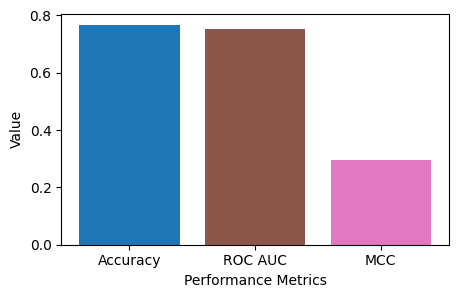

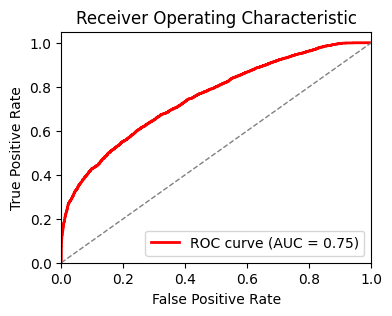

In [19]:
# Calculate performance metrics using the predicted labels and true labels
acc, roc_auc, mcc = get_performance_metrics(y_test_pred, test_labels)

# Print the calculated performance metrics
print(f"Accuracy on test set: {acc:.4f}")
print(f"ROC AUC Score on test set: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient on test set: {mcc:.4f}")

# Plot the performance metrics
plot_performance_metrics(acc, roc_auc, mcc)

# Plot the ROC curve
plot_roc_curve(test_labels, y_test_pred)

### Question 4 Please increase num_rounds, what will happen?


______________________________________________________________

## 3 Machine Learning Parameter Optimization

Parameter optimization is a crucial step in the machine learning pipeline. It involves tuning the hyperparameters of a model to achieve the best possible performance on a given task. Hyperparameters are settings that are not learned from the data but are set by the user before training begins. Effective parameter optimization can significantly improve the model's accuracy and generalization capabilities. Common techniques for parameter optimization include:
- **Grid Search**: This method involves defining a grid of hyperparameter values and exhaustively searching through all possible combinations. While simple, it can be computationally expensive, especially with a large number of hyperparameters.
- **Random Search**: Instead of searching through all combinations, random search randomly samples hyperparameter values from predefined distributions. This approach is often more efficient than grid search, especially when some hyperparameters have a larger impact on performance.
- **Bayesian Optimization**: This technique uses probabilistic models to predict which hyperparameters are likely to yield the best performance. It iteratively selects the next set of hyperparameters to evaluate based on the results of previous evaluations, making it more efficient than grid and random search.
- **Gradient-Based Optimization**: For differentiable models, gradient-based methods like gradient descent can be used to optimize hyperparameters directly. This is particularly effective for neural networks.

In [20]:
from hyperopt import fmin, tpe, hp, Trials, rand

# Define an array of possible values for the max_depth parameter.
depth_array = [6, 7, 8, 9, 10, 11, 12, 13, 14]

# Define the search space for the Gradient Boosting model parameters.
space_gradient_boosting = {"learning_rate": hp.uniform("learning_rate", 0.01, 0.5),  # Learning rate for reducing the contribution of each tree.
                           "max_depth": hp.choice("max_depth", depth_array), # Maximum depth of the tree
                           "reg_lambda": hp.uniform("reg_lambda", 0, 5),  # L2 regularization term on weights.
                           "reg_alpha": hp.uniform("reg_alpha", 0, 5),  # L1 regularization term on weights.
                           "max_delta_step": hp.uniform("max_delta_step", 0, 5), # Maximum delta step we allow each tree's weight estimation to be.
                           "min_child_weight": hp.uniform("min_child_weight", 0.1, 15), # Minimum sum of instance weight (hessian) needed in a child.
                           "num_rounds": hp.uniform("num_rounds", 30, 100), # Number of boosting rounds
                           "weight": hp.uniform("weight", 0.01, 0.99)} # Class weight for the negative class

# Function to calculate the performance using Matthews correlation coefficient (MCC).
def get_performance(pred, true):
    MCC = matthews_corrcoef(true, np.round(pred))  # Calculate MCC between predicted and true labels.
    return (-MCC)  # Return the negative MCC since Hyperopt minimizes the objective function.


In [21]:
def set_param_values(param):
    """
    Set specific parameter values for XGBoost and handle class weights.
    
    Parameters:
    param (dict): Dictionary of parameters for XGBoost.
    
    Returns:
    tuple: Updated parameter dictionary and number of boosting rounds.
    """
    num_round = int(param["num_rounds"])
    param["tree_method"] = "hist"  # Use histogram-based algorithm
    param["device"] = "cuda"  # Use GPU for training
    param["sampling_method"] = "gradient_based"  # Sampling method for histogram bins
    param['objective'] = 'binary:logistic'  # Binary classification objective
    param['seed'] = 42  # Random seed for reproducibility
    
    # Set class weights for the training data
    weights = np.array([param["weight"] if y == 0 else 1.0 for y in dtrain.get_label()])
    dtrain.set_weight(weights)
    
    # Remove the 'num_rounds' and 'weight' keys from the parameter dictionary
    del param["num_rounds"]
    del param["weight"]
    
    return (param, num_round)
    
def train_xgboost_model_all(param):
    """
    Train an XGBoost model with the given parameters and evaluate its performance.
    
    Parameters:
    param (dict): Dictionary of parameters for XGBoost.
    
    Returns:
    float: Negative ROC AUC score (to minimize in hyperparameter optimization).
    """
    param, num_round = set_param_values(param)
    # Training:
    bst = xgb.train(param, dtrain, num_round)
    return (get_performance(pred=bst.predict(dvalid), true=val_labels))

# Initialize the Trials object to track the optimization process
trials = Trials()

# Perform hyperparameter optimization using random search
best = fmin(fn=train_xgboost_model_all, space=space_gradient_boosting,
                algo=rand.suggest, max_evals=20, trials=trials)

print("Best parameters found:", best)

100%|██████████| 20/20 [00:32<00:00,  1.62s/trial, best loss: -0.741607599894083]
Best parameters found: {'learning_rate': np.float64(0.17987428338707856), 'max_delta_step': np.float64(1.0191536905587912), 'max_depth': np.int64(5), 'min_child_weight': np.float64(11.945323163334018), 'num_rounds': np.float64(96.38045536562724), 'reg_alpha': np.float64(2.3573777758565817), 'reg_lambda': np.float64(1.443808858619241), 'weight': np.float64(0.4588433164732094)}


Accuracy on test set: 0.8226
ROC AUC Score on test set: 0.8442
Matthews Correlation Coefficient on test set: 0.5191


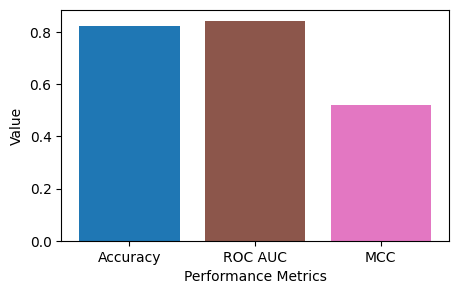

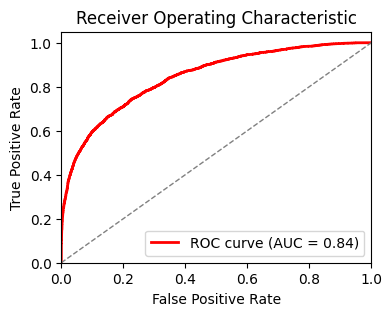

In [22]:
# Set the best parameters found by hyperparameter optimization
param, num_round = set_param_values(best)

# Train the XGBoost model with the best parameters
model = xgb.train(param, dtrain, num_round)

# Make predictions on the test set
y_test_pred = model.predict(dtest)

# Calculate performance metrics for the test set
acc, roc_auc, mcc = get_performance_metrics(y_test_pred, test_labels)

# Print the performance metrics
print(f"Accuracy on test set: {acc:.4f}")
print(f"ROC AUC Score on test set: {roc_auc:.4f}")
print(f"Matthews Correlation Coefficient on test set: {mcc:.4f}")

# Plot the performance metrics
plot_performance_metrics(acc, roc_auc, mcc)

# Draw the ROC curve for the test set
plot_roc_curve(test_labels, y_test_pred)

#### **Question 5** Can you optimize hyperparameters using a grid search optimization strategy?


-
___________________________________________________________________________________

## 4. Integrated Machine Learning Models
### 4.1 Extract combining feature using deep learning model
In addition to directly concatenating protein sequence features with substrate features, deep learning models can be used to combine these features more effectively. Neural networks can learn complex interactions between the features, improving model performance. Common approaches include:
- **Concatenated Input Layers**: Feeding protein and substrate features into separate input layers and concatenating them later.
- **Attention Mechanisms**: Using attention to dynamically weigh the importance of different features.
- **Multi-Modal Fusion**: Integrating information from both features in a sophisticated manner to capture cross-modal interactions.
- **Example**:
    - Combining protein and substrate feature using deep learning model from Prosmith (cls).

In [23]:
from modules import MM_TN, MM_TNConfig
import os

# Define the configuration for the MM_TN model
config = MM_TNConfig.from_dict({
    "s_hidden_size": 600,       # Hidden size for substrate features
    "p_hidden_size": 1280,      # Hidden size for protein sequence features
    "hidden_size": 768,         # Combined hidden size
    "max_seq_len": 1276,        # Maximum sequence length
    "num_hidden_layers": 6,     # Number of hidden layers
    "binary_task": True         # Whether the task is binary classification
})

# Initialize the MM_TN model with the specified configuration
model = MM_TN(config)

# Set the device to GPU if available
device = torch.device("cuda")
model = model.to(device)  # Move the model to the GPU

# Path to the pretrained model weights
pretain_path = '/data/home/jiahao/class2/pretraining_IC50_6gpus_bs144_1.5e-05_layers6.txt.pkl'

# Check if the pretrained model weights file exists
if os.path.exists(pretain_path):
    # Load the pretrained model weights
    state_dict = torch.load(pretain_path)
    
    # Get the current state dictionary of the model
    new_model_state_dict = model.state_dict()
    
    # Copy the pretrained weights to the current model
    for key in new_model_state_dict.keys():
        if key in state_dict.keys():
            try:
                new_model_state_dict[key].copy_(state_dict[key])
                # logging.info("Updated key: %s" % key)
            except:
                pass  # Ignore any keys that cannot be copied
    
    # Load the updated state dictionary back into the model
    model.load_state_dict(new_model_state_dict)

# Set the model to evaluation mode
model.eval()

MM_TN(
  (s_pooler): BertSmilesPooler(
    (dense): Linear(in_features=600, out_features=768, bias=True)
    (activation): ReLU()
  )
  (p_pooler): BertProteinPooler(
    (dense): Linear(in_features=1280, out_features=768, bias=True)
    (activation): ReLU()
  )
  (main_bert): Bert(
    (transformer_layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (hidden_layer): Linear(in_feat

The deep learning model uses the enzyme features and substrate features obtained from the feature extraction code above to extract the combined features.

In [24]:
# Extract the first 256 elements from the last layer representation of the SMILES embedding
smiles_emb = last_layer_repr[:256]  # Shape: torch.Size([600])

# Extract the first 1024 elements from the ESM protein embedding
protein_emb = protein_emb_esm[:1024]  # Shape: torch.Size([1024])

# Create an attention mask for the SMILES embedding
smiles_attn_mask = torch.zeros(256)  # Initialize a tensor of zeros with shape (256,)
smiles_attn_mask[:smiles_emb.shape[0]] = 1  # Set the first `smiles_emb.shape[0]` elements to 1

# Create an attention mask for the protein embedding
protein_attn_mask = torch.zeros(1024)  # Initialize a tensor of zeros with shape (1024,)
protein_attn_mask[:protein_emb.shape[0]] = 1  # Set the first `protein_emb.shape[0]` elements to 1

# Define padding for the SMILES embedding to ensure it has a fixed size of (256, 256)
smiles_padding = (0, 0, 0, 256 - smiles_emb.shape[1])

# Define padding for the protein embedding to ensure it has a fixed size of (1024, 1024)
prot_padding = (0, 0, 0, 1024 - protein_emb.shape[1])

# Apply padding to the SMILES embedding
smiles_emb = torch.nn.functional.pad(smiles_emb, smiles_padding, mode='constant', value=0)

# Apply padding to the protein embedding
protein_emb = torch.nn.functional.pad(protein_emb, prot_padding, mode='constant', value=0)
print('The shape of protein embedding is:', protein_emb.shape)
print('The padding protein embedding is:', protein_emb)
print('The shape of substrate embedding is', smiles_emb.shape)
print('The padding substrate embedding is:', smiles_emb)

The shape of protein embedding is: torch.Size([1, 1024, 1280])
The padding protein embedding is: tensor([[[ 0.0758,  0.0112,  0.0675,  ..., -0.2298,  0.1255, -0.0867],
         [-0.0311,  0.0249,  0.0155,  ...,  0.0558, -0.0818,  0.0376],
         [ 0.0782,  0.0190,  0.0347,  ...,  0.2752, -0.1195,  0.0635],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       device='cuda:0')
The shape of substrate embedding is torch.Size([1, 256, 600])
The padding substrate embedding is: tensor([[[ 0.0048,  0.0000,  0.3266,  ...,  0.3541,  0.8186,  0.3482],
         [ 1.5164,  0.0000, -0.0092,  ...,  0.1795,  0.5670,  0.2165],
         [ 1.5115,  0.0000, -0.0049,  ...,  0.1796,  0.5666,  0.2165],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...

In [25]:
# Move the embeddings and model to the specified device (GPU)
smiles_emb = smiles_emb.to(device).detach()
smiles_attn_mask = smiles_attn_mask.to(device).view(1,-1)
protein_emb = protein_emb.to(device).detach()
protein_attn_mask = protein_attn_mask.to(device).view(1,-1)
model = model.to(device)

In [26]:
# Using deep learning model to combine enzyme and substrate feature
_, cls_repr = model(smiles_emb=smiles_emb,
                                smiles_attn=smiles_attn_mask,
                                protein_emb=protein_emb,
                                protein_attn=protein_attn_mask,
                                device=device,
                                get_repr=True)

print('The representation of combining enzyme and substrate feature using deep learning model is:', cls_repr)
print('The shape of combining feature is:', cls_repr.size())

The representation of combining enzyme and substrate feature using deep learning model is: tensor([[ 2.9440e-01,  1.6698e-01,  1.2289e+00,  1.9069e+00, -5.9087e-01,
          1.4725e+00, -5.2538e-01,  5.2604e-01,  1.4508e+00, -1.0444e+00,
         -3.0570e-01,  3.6918e-01, -1.4852e+00,  2.7426e-01,  5.4781e-02,
          1.8194e-01,  8.4170e-01, -1.3494e+00,  7.3188e-01,  1.5364e+00,
          5.1108e-01,  5.2234e-01, -5.4743e-01,  1.9070e+00, -1.6604e+00,
         -1.0360e+00,  7.1105e-01,  2.5750e-02,  5.7098e-01,  1.3308e+00,
          1.9992e+00,  6.6393e-01, -8.5996e-02,  3.2547e-01, -1.0779e+00,
         -7.1197e-01, -5.6888e-01, -2.5683e-02, -8.1777e-01,  1.3787e+00,
          8.6857e-01,  9.3547e-01, -4.2221e-01,  9.5204e-01,  1.9720e+00,
          1.0012e+00,  2.0261e+00, -1.5494e+00,  3.6438e-01,  8.7481e-01,
         -7.4811e-01,  8.4955e-01,  7.4223e-01,  7.8291e-01,  5.5889e-01,
         -1.3738e+00,  6.8287e-01, -2.3819e-01, -1.5147e+00, -1.1014e+00,
         -4.5548e-01,

### 4.2 Training and integrated XGBoost
- In addition to concatenating the substrate and enzyme features, we can also concatenate the enzyme, substrate, and the combined features extracted by a deep learning model. 
- Alternatively, we can directly use the extracted combined features to train a machine learning model. 
- By training three separate machine learning models—each using a different set of features (enzyme and substrate features, combined features, and all features concatenated)—we can then integrate the predictions from these models to make a more robust and accurate final prediction. This ensemble method combines the strengths of each individual model to improve overall performance.

In [27]:
# Load validation data
val_cls, val_esm1b, val_smiles, val_labels = loaded_val['val_cls'], loaded_val['val_esm1b'], loaded_val['val_smiles'], loaded_val['val_labels']

# Load test data
test_cls, test_esm1b, test_smiles, test_labels, test_indices = loaded_test['test_cls'], loaded_test['test_esm1b'], loaded_test['test_smiles'], loaded_test['test_labels'], loaded_test['test_indices']

# Load training data
train_cls, train_esm1b, train_smiles, train_labels = loaded_train['train_cls'], loaded_train['train_esm1b'], loaded_train['train_smiles'], loaded_train['train_labels']

############# cls token
# Convert the training, validation, and test data for the cls token to DMatrix format for XGBoost
dtrain_cls = xgb.DMatrix(np.array(train_cls), label=np.array(train_labels).astype(float))
dvalid_cls = xgb.DMatrix(np.array(val_cls), label=np.array(val_labels).astype(float))
dtest_cls = xgb.DMatrix(np.array(test_cls), label=np.array(test_labels).astype(float))

# Train the XGBoost model using the cls token features
model_cls = xgb.train(params, dtrain_cls, num_rounds)

# Predict the validation set labels using the trained model
y_val_pred_cls = model_cls.predict(dvalid_cls)

############# ESM2+ChemBERTa +cls
# Concatenate the ESM1b, ChemBERTa, and cls token features for training, validation, and test sets
train_X_all_cls = np.concatenate([np.concatenate([train_esm1b, train_smiles], axis=1), train_cls], axis=1)
test_X_all_cls = np.concatenate([np.concatenate([test_esm1b, test_smiles], axis=1), test_cls], axis=1)
val_X_all_cls = np.concatenate([np.concatenate([val_esm1b, val_smiles], axis=1), val_cls], axis=1)

# Convert the concatenated features to DMatrix format for XGBoost
dtrain_all_cls = xgb.DMatrix(np.array(train_X_all_cls), label=np.array(train_labels).astype(float))
dtest_all_cls = xgb.DMatrix(np.array(test_X_all_cls), label=np.array(test_labels).astype(float))
dvalid_all_cls = xgb.DMatrix(np.array(val_X_all_cls), label=np.array(val_labels).astype(float))

# Train the XGBoost model using the concatenated features
model_all_cls = xgb.train(params, dtrain_all_cls, num_rounds)

# Predict the validation set labels using the trained model
y_val_pred_all_cls = model_all_cls.predict(dvalid_all_cls)

In [28]:
# Initialize the best Matthews Correlation Coefficient (MCC) and Mean Squared Error (MSE)
best_mcc, best_mse = 0, 1000
best_i, best_j, best_k = 0, 0, 0

# Iterate over possible values of i and j (both ranging from 0 to 1 in steps of 0.01)
for i in [k / 100 for k in range(0, 100)]:
    for j in [k / 100 for k in range(0, 100)]:
        # Ensure that the sum of i and j does not exceed 1
        if i + j <= 1:
            # Calculate the value of k such that i + j + k = 1
            k = 1 - i - j
            
            # Compute the weighted prediction using the three sets of predictions
            y_val_pred = i * y_val_pred_all_cls + j * y_val_pred_all + k * y_val_pred_cls
            
            # Calculate the Matthews Correlation Coefficient (MCC) for the current weighted prediction
            mcc = matthews_corrcoef(val_labels, np.round(y_val_pred))
            
            # Update the best MCC and corresponding weights if the current MCC is better
            if mcc > best_mcc:
                best_mcc = mcc
                best_i, best_j, best_k = i, j, k

In [29]:
print(f'Best i: {best_i}, Best j: {best_j}, Best k: {best_k}')

Best i: 0.91, Best j: 0.03, Best k: 0.05999999999999997


#### **Question 6** Can you indicate which type of feature had the least effect on the outcome and which had the most effect on the outcome based on the above?


-
___________________________________________________________________________________

#### **Question 7** Can you use the integration model to predict the outcome of the test set and give the accuracy, ROC curve and MCC on the test set?


-
___________________________________________________________________________________